In [1]:
import pandas as pd
import numpy as np
import time
import re
from collections import Counter
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import gensim
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

/Users/paul.zhang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paul.zhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
aliens = pd.read_csv('archive/sf_aliens.csv',encoding = 'utf-8')
aliens["type"] = "aliens"
history =pd.read_csv('archive/sf_alternate_history.csv',encoding = 'utf-8')
history["type"] = "history"
universe=pd.read_csv('archive/sf_alternate_universe.csv',encoding = 'utf-8')
universe["type"] = "universe"
apocalyptic = pd.read_csv('archive/sf_apocalyptic.csv',encoding = 'utf-8')
apocalyptic["type"] = "apocalyptic"
cyberpunk =pd.read_csv('archive/sf_cyberpunk.csv',encoding = 'utf-8')
cyberpunk["type"] = "cyberpunk"
dystopia = pd.read_csv('archive/sf_dystopia.csv',encoding = 'utf-8')
dystopia["type"] = "dystopia"
hard=pd.read_csv('archive/sf_hard.csv',encoding = 'utf-8')
hard["type"] = "hard"
military=pd.read_csv('archive/sf_military.csv',encoding = 'utf-8')
military["type"] = "military"
robots=pd.read_csv('archive/sf_robots.csv',encoding = 'utf-8')
robots["type"] = "robots"
space=pd.read_csv('archive/sf_space_opera.csv',encoding = 'utf-8')
space["type"] = "space opera"
steampunk=pd.read_csv('archive/sf_steampunk.csv',encoding = 'utf-8')
steampunk["type"] = "steampunk"
time_travel=pd.read_csv('archive/sf_time_travel.csv',encoding = 'utf-8')
time_travel["type"] = "time travel"


In [3]:
df=pd.DataFrame()
df=pd.concat([df,aliens])
df = pd.concat([df,history])
df=pd.concat([df,universe])
df=pd.concat([df,apocalyptic])
df=pd.concat([df,cyberpunk])
df=pd.concat([df,robots])
df=pd.concat([df,space])
df=pd.concat([df,steampunk])
df=pd.concat([df,dystopia])
df=pd.concat([df,hard])
df=pd.concat([df,military])
df=pd.concat([df,time_travel])
df = df.reset_index()

Starting over sucks.When we moved to West Virginia right before my senior year, I’d pretty much resigned myself to thick accents, dodgy internet access, and a whole lot of boring… until I spotted my hot neighbor, with his looming height and eerie green eyes. Things were looking up.And then he opened his mouth.Daemon is infuriating. Arrogant. Stab-worthy. We do not get along. At all. But when a stranger attacks me and Daemon literally freezes time with a wave of his hand, well, something… unexpected happens. The hot alien living next door marks me.You heard me. Alien. Turns out Daemon and his sister have a galaxy of enemies wanting to steal their abilities, and Daemon’s touch has me lit up like the Vegas Strip. The only way I’m getting out of this alive is by sticking close to Daemon until my alien mojo fades. If I don’t kill him first, that is.


In [33]:
df = df[['Book_Title','Rating_score','Rating_votes','Review_number','Book_Description','type','url']]
df = df.dropna(subset=["Book_Description"])
df = df.reset_index()
stop_words = set(stopwords.words('english'))

In [34]:
def cleanup_review(desc):
    if type(desc) == float:
        desc = ""
    words = [re.sub(r'[^a-z]', '', w) for w in desc.lower().split(' ')]
    return ' '.join(words)

def reduce_to_vocabulary(desc, vocab):
    return ' '.join([w for w in cleanup_review(desc).split(' ') if w in vocab])



In [35]:
vocab = Counter()
for review in df.Book_Description:
    vocab.update(cleanup_review(review).split(' '))

68298
84696


In [204]:
vocab = Counter(token for token in vocab.elements() if vocab[token] > 5)
stop_words = [item[0] for item in vocab.most_common(100)]
vocab = Counter(token for token in vocab.elements() if token not in stop_words and token not in stopwords.words('english'))

del vocab['']

17987


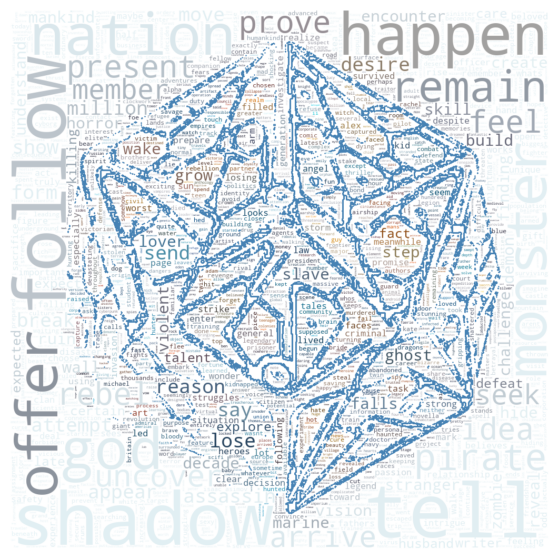

In [206]:
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
long_string = ','.join([reduce_to_vocabulary(desc,vocab) for desc in list(df.Book_Description)])
mask = np.array(Image.open("cube3.png"))
image_colors = ImageColorGenerator(mask)
wordcloud = WordCloud(background_color = 'white',mask = mask, max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud


# lower max_font_size
fig = plt.figure()
fig.set_size_inches(7,7)
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()
#wordcloud.to_file('dice1.png')

In [207]:
id2word = {idx:pair[0] for idx,pair in enumerate(vocab.items())}
word2id = {pair[0]:idx for idx,pair in enumerate(vocab.items())}

s = 'rush'
print("Number of tokens mapped: %d" % len(id2word))
print("Identifier for '%s': %d" % (s,word2id[s]))
print("Word for identifier %d: %s" % (word2id[s], id2word[word2id[s]]))

Number of tokens mapped: 17987
Identifier for 'rush': 5402
Word for identifier 5402: rush


In [208]:
def get_token(df = df):
    tokens = []
    for desc in df.Book_Description:
        clean = reduce_to_vocabulary(cleanup_review(desc),vocab)
        toks = clean.split(' ')
        tokens.append(toks)
    return tokens

tokens = get_token()

In [209]:
def get_corpus(tokens,corpus = None):
    if corpus == None:
        corpus = []
    for toks in tokens:
        tkn_count = Counter(toks)
        corpus.append([(word2id[item[0]],item[1]) for item in tkn_count.items() if item[0] != ''])
    return corpus

corpus = get_corpus(tokens)

In [268]:
%%time
num_topics=40
tm = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                     id2word=id2word,
                                     num_topics=num_topics, 
                                     random_state=100,
                                     chunksize=100,
                                     passes=10,
                                     alpha='auto',
                                     per_word_topics=True)

CPU times: user 59.2 s, sys: 4.98 s, total: 1min 4s
Wall time: 58.3 s


In [287]:
num_words = 30
top_words = pd.DataFrame({'word rank': np.arange(1,num_words+1)})
for k in np.arange(num_topics): 
    topic = tm.get_topic_terms(k, num_words)
    words = [id2word[topic[i][0]] for i in np.arange(num_words)]
    probs = [topic[i][1] for i in np.arange(num_words)]
    top_words['topic %d' % k] = words

top_words

,word rank,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,...,topic 30,topic 31,topic 32,topic 33,topic 34,topic 35,topic 36,topic 37,topic 38,topic 39
0,1,pirates,idea,maybe,met,puzzle,student,falls,walking,quiet,...,bride,career,finding,general,originally,global,falling,pirate,beloved,existed
1,2,exciting,latest,calls,tells,rose,travelers,hole,suspect,clan,...,legendary,faces,mankind,elite,half,preparing,husband,ben,shed,sees
2,3,aboard,runs,saved,security,break,party,sexy,blast,whos,...,looks,blue,standing,normal,important,appears,arrives,ruins,today,filled
3,4,encounters,baby,survived,thriller,point,arthur,lose,stranger,disaster,...,sword,situation,facing,violent,contains,starts,major,seven,realize,choose
4,5,early,martin,class,terror,leading,guide,wakes,form,supposed,...,seeks,fierce,shadows,desperately,warning,seem,happens,success,none,late
5,6,youre,armies,promise,jump,step,presence,move,leaves,cassie,...,twist,whatever,stands,older,silver,thrown,especially,completely,arent,hot
6,7,encounter,cosmic,feelings,visions,unravel,president,forward,mans,pay,...,show,decides,imagine,bed,fix,perhaps,marriage,wishes,featuring,rather
7,8,couple,vicious,prisoner,grand,clear,pair,tries,million,siege,...,population,legacy,started,experiment,monsters,scientist,fallen,systems,guard,remains
8,9,learned,neighbor,frightening,spy,resist,girlfriend,white,agents,passes,...,period,sinister,foe,bit,sex,fellow,guy,rise,unlikely,prize
9,10,thanks,otherworldly,cruel,needed,walls,obsessed,returned,agency,bounty,...,recently,wake,entirely,process,funny,stuck,remote,sisters,notorious,teach


In [270]:
def preprocess_new_text(text):
    clean = reduce_to_vocabulary(cleanup_review(text),vocab)
    tokens = clean.split(' ')
    token = [tok for tok in tokens if tok in word2id.keys()]
    preprocessed_text = []
    tkn_count = Counter(token)
    preprocessed_text = [(word2id[item[0]],item[1]) for item in tkn_count.items() if item[0] != '']
    return preprocessed_text



In [271]:
def get_topic_table(example = None, df = corpus, text = None):
    if example == None:
        topic_dist = tm.get_document_topics(preprocess_new_text(text))
    else:
        topic_dist = tm.get_document_topics(corpus[example])
    topics = [pair[0] for pair in topic_dist]
    probabilities = [pair[1] for pair in topic_dist]
    topic_dist_table = pd.DataFrame()
    topic_dist_table['Topic'] = topics
    topic_dist_table['Probabilities'] = probabilities
    return topic_dist_table



In [272]:
text = 'In a bleak future Earth, bounty hunter Rick Deckard hunts down renegade androids. In his world, owning live animals is a mark of social status, but most people can only afford electronic pets. As Deckard pursues his dangerous quarry, he begins to question the boundaries between human and artificial intelligence. His encounters with increasingly human-like androids force him to confront his own beliefs about empathy, identity, and what it truly means to be alive in a world where the line between man and machine is blurred.'
topic_dist_table = get_topic_table(example = 9, text = text)



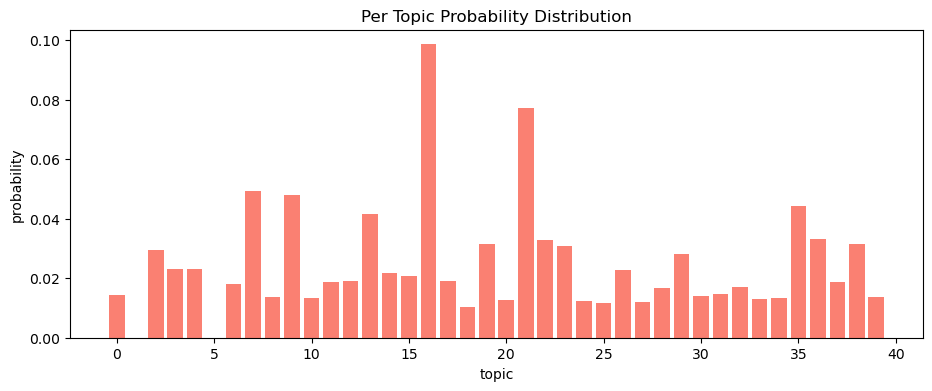

In [273]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(11,4)
plt.bar(topic_dist_table['Topic'], topic_dist_table['Probabilities'], align='center', alpha=1, color='salmon')
plt.xlabel('topic')
plt.ylabel('probability')
plt.title('Per Topic Probability Distribution')
plt.show()

In [274]:
theta = pd.DataFrame({"Theta0": np.zeros(df.shape[0])})
for t in np.arange(1,num_topics):
    theta["Theta"+str(t)] = np.zeros(df.shape[0])
    
for i in np.arange(df.shape[0]):
    for t in tm.get_document_topics(corpus[i]):
        theta.loc[i,"Theta"+str(t[0])] = t[1]
print(theta)
        

         Theta0    Theta1    Theta2    Theta3    Theta4    Theta5    Theta6  \
0      0.010462  0.016139  0.010040  0.016864  0.016802  0.000000  0.024645   
1      0.024423  0.000000  0.011193  0.018801  0.018732  0.000000  0.014717   
2      0.011814  0.018228  0.011338  0.019044  0.018974  0.000000  0.014907   
3      0.012458  0.000000  0.011956  0.292693  0.020008  0.000000  0.015720   
4      0.012630  0.000000  0.025939  0.020359  0.034103  0.000000  0.015937   
...         ...       ...       ...       ...       ...       ...       ...   
14898  0.025738  0.000000  0.025243  0.019812  0.019739  0.047705  0.042404   
14899  0.017127  0.000000  0.016437  0.027607  0.027506  0.010259  0.021610   
14900  0.015932  0.000000  0.015290  0.025682  0.043020  0.000000  0.020104   
14901  0.014894  0.000000  0.014294  0.024008  0.023920  0.000000  0.035089   
14902  0.014424  0.000000  0.013843  0.023250  0.023165  0.000000  0.018200   

         Theta7    Theta8    Theta9  ...   Theta30 

In [275]:
df_topics = df.join(theta)
df_topics

,index,Book_Title,Rating_score,Rating_votes,Review_number,Book_Description,type,url,Theta0,Theta1,...,Theta30,Theta31,Theta32,Theta33,Theta34,Theta35,Theta36,Theta37,Theta38,Theta39
0,0,Obsidian,4.17,236780,18161,Starting over sucks.When we moved to West Virg...,aliens,https://www.goodreads.com/book/show/12578077-o...,0.010462,0.016139,...,0.010256,0.010648,0.012261,0.020901,0.021047,0.032176,0.024041,0.013634,0.022734,0.032831
1,1,Onyx,4.27,153429,10497,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,aliens,https://www.goodreads.com/book/show/13047090-onyx,0.024423,0.000000,...,0.011434,0.011871,0.013669,0.010542,0.010706,0.048632,0.026803,0.027958,0.012586,0.023841
2,2,The 5th Wave,4.03,400600,29990,"After the 1st wave, only darkness remains. Aft...",aliens,https://www.goodreads.com/book/show/16101128-t...,0.011814,0.018228,...,0.024505,0.012024,0.013846,0.010678,0.010845,0.049259,0.014223,0.015396,0.012749,0.101705
3,3,The Host,3.84,915026,41673,Melanie Stryder refuses to fade away. The eart...,aliens,https://www.goodreads.com/book/show/1656001.Th...,0.012458,0.000000,...,0.012213,0.012679,0.014601,0.011260,0.011436,0.051943,0.014998,0.016235,0.013443,0.011835
4,4,Opal,4.27,129006,9463,No one is like Daemon Black.When he set out to...,aliens,https://www.goodreads.com/book/show/13362536-opal,0.012630,0.000000,...,0.012381,0.012855,0.028618,0.011416,0.011594,0.038845,0.015206,0.016460,0.041267,0.011999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14898,14898,Tumbling Through Time,3.34,312,51,"In her sparkling and hilarious debut, author G...",time travel,https://www.goodreads.com/book/show/1888734.Tu...,0.025738,0.000000,...,0.012048,0.025956,0.027852,0.011109,0.024727,0.091591,0.028242,0.029464,0.026705,0.011676
14899,14899,Time's Arrow,3.71,14934,1106,In Time's Arrow the doctor Tod T. Friendly die...,time travel,https://www.goodreads.com/book/show/23031.Time...,0.017127,0.000000,...,0.016789,0.017431,0.020072,0.015479,0.015721,0.052674,0.020619,0.022319,0.018481,0.016271
14900,14900,Time Out of Joint,3.85,11126,688,Time Out of Joint is Philip K. Dick’s classic ...,time travel,https://www.goodreads.com/book/show/698034.Tim...,0.015932,0.000000,...,0.015618,0.016215,0.018672,0.014400,0.014625,0.049001,0.019181,0.020763,0.017192,0.015136
14901,14901,Fog Magic,3.88,1204,170,"Originally published in 1943, this edition fea...",time travel,https://www.goodreads.com/book/show/297891.Fog...,0.014894,0.000000,...,0.014600,0.015158,0.017455,0.013461,0.029968,0.045807,0.017931,0.019410,0.016072,0.030445


In [276]:
df_topic_bar = df_topics.groupby(by = 'type')[['Theta' + str(i) for i in range(num_topics)]].sum().reset_index()
df_topic_bar = pd.DataFrame(df_topic_bar.values.T,columns = df_topic_bar['type'],index = df_topic_bar.columns).reset_index(drop = False)
df_topic_bar = df_topic_bar.drop(index = [0]).reset_index(drop = True)
df_topic_bar = df_topic_bar.rename(columns = {'index':'label'})


def divide_by_row_sum(row):
    row_sum = row.sum()
    return ((row) / (row_sum+0.0000000001))


label = df_topic_bar.label
df_topic_bar = df_topic_bar.iloc[:,1:].apply(divide_by_row_sum, axis=1)
df_topic_bar.insert(0,'label',label)

type,label,aliens,apocalyptic,cyberpunk,dystopia,hard,history,military,robots,space opera,steampunk,time travel,universe
0,Theta0,0.081625,0.078454,0.081640,0.077949,0.087417,0.083492,0.088399,0.084144,0.094555,0.085079,0.079410,0.077835
1,Theta1,0.113307,0.074006,0.081449,0.076560,0.058812,0.089678,0.062367,0.081996,0.074196,0.084438,0.101312,0.101880
2,Theta2,0.088290,0.082659,0.083642,0.087457,0.077595,0.083731,0.082082,0.082559,0.082170,0.083528,0.079424,0.086862
3,Theta3,0.079632,0.082652,0.084932,0.083054,0.084272,0.085599,0.086726,0.083255,0.086318,0.082388,0.080487,0.080685
4,Theta4,0.077739,0.083661,0.085405,0.083345,0.082636,0.086312,0.079525,0.083177,0.082212,0.086074,0.086484,0.083429
5,Theta5,0.075968,0.074629,0.089235,0.073260,0.088319,0.089915,0.071158,0.101430,0.082084,0.065091,0.111001,0.077911
6,Theta6,0.090347,0.084020,0.078953,0.084654,0.079660,0.083261,0.080305,0.081152,0.079800,0.082509,0.090737,0.084603
7,Theta7,0.081065,0.087205,0.085407,0.082950,0.084485,0.081791,0.081352,0.083435,0.082595,0.082981,0.082913,0.083821
8,Theta8,0.083308,0.081795,0.081938,0.080611,0.079301,0.085267,0.082761,0.079715,0.085191,0.085953,0.084405,0.089755
9,Theta9,0.085410,0.082275,0.079809,0.083967,0.080152,0.083960,0.084339,0.082950,0.082827,0.084137,0.087112,0.083063


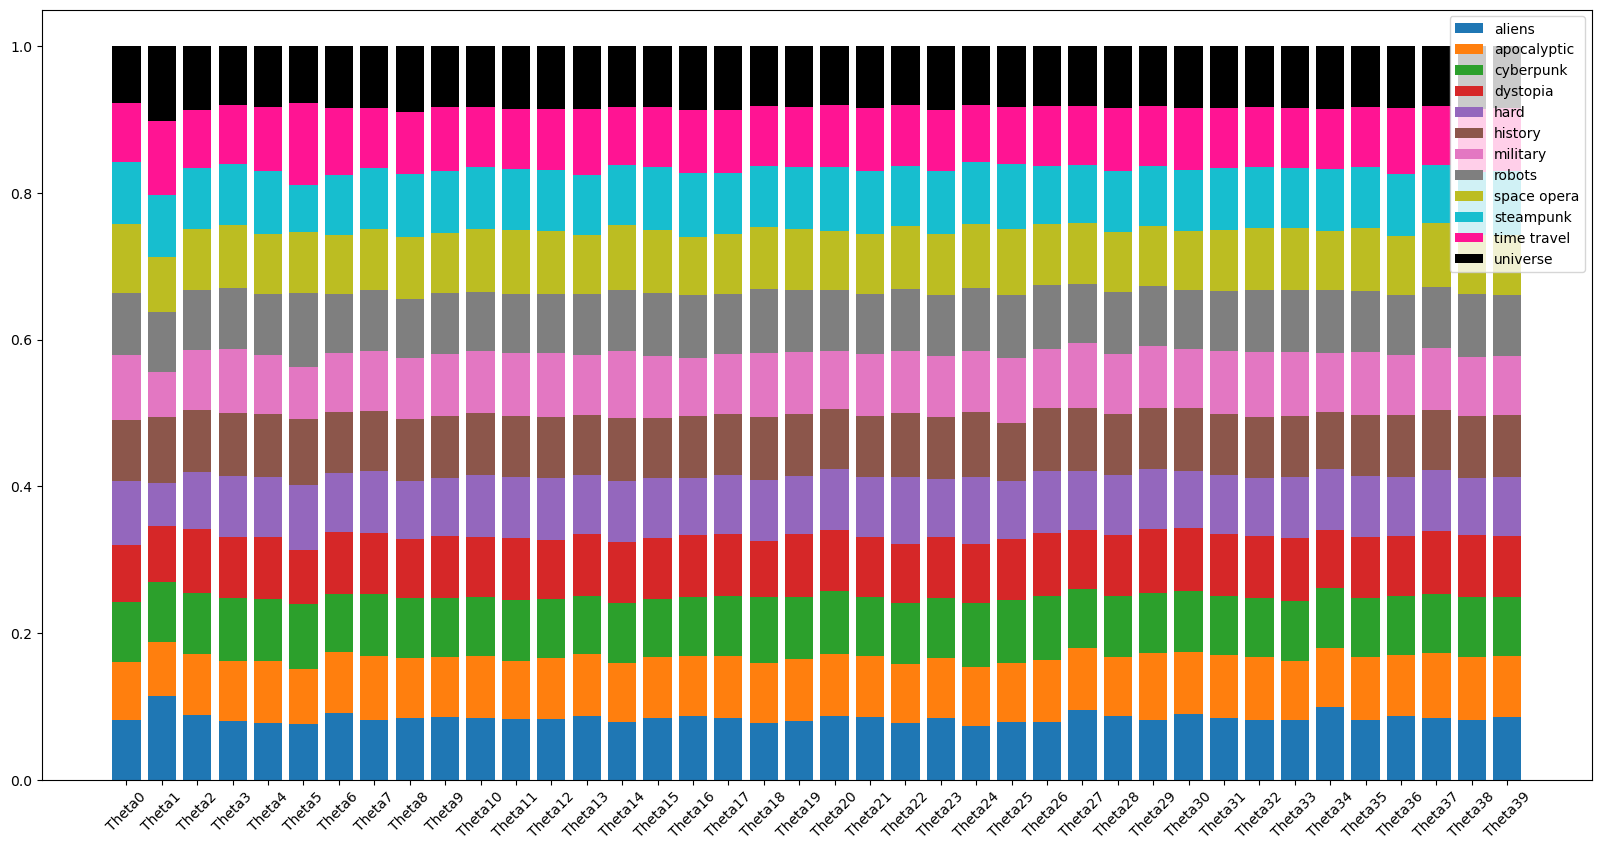

In [277]:
fig,ax = plt.subplots(figsize= (20,10))
labels = df_topic_bar.label
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff1493', 'black']

ax.bar(labels,df_topic_bar['aliens'],label = 'aliens',color = colors[0])
for i in range(2,df_topic_bar.shape[1]):
    ax.bar(labels,df_topic_bar[df_topic_bar.columns[i]].values, bottom = (df_topic_bar.iloc[:,1:i].sum(axis = 1)), 
           label = df_topic_bar.columns[i],color = colors[i-1])
ax.legend()
plt.xticks(rotation = 45)
plt.show()

In [280]:
#text = '"Back to the Future" is a beloved science fiction film series directed by Robert Zemeckis. It follows the adventures of Marty McFly, a teenager, and his eccentric scientist friend, Dr. Emmett "Doc" Brown. The story begins when Doc Brown invents a time machine in the form of a DeLorean car, accidentally sending Marty back in time to the 1950s. There, Marty encounters his young parents and inadvertently disrupts the course of history. The heart of the series lies in Marty\'s efforts to set things right and ensure his parents fall in love, all while dealing with the complexities of time travel. Throughout the trilogy, Marty and Doc travel between the past, present, and future, encountering various challenges, paradoxes, and unexpected consequences. "Back to the Future" is renowned for its clever blend of science fiction, comedy, and adventure, exploring themes of destiny, family, and the ripple effects of one\'s actions in a time-altering journey. The series consists of three films: "Back to the Future" (1985), "Back to the Future Part II" (1989), and "Back to the Future Part III" (1990). Together, they form a timeless and entertaining tale of time travel and the enduring bond between friends, making "Back to the Future" one of the most iconic and beloved franchises in cinema history.'
topic_table = get_topic_table(example = None, df = corpus, text = text)

In [281]:
def cosine_similarity(A, B):
    return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))

def get_top_k_similarity(k,text,df_topics = df_topics):
    d = {}
    topic_table = get_topic_table(example = None, df = corpus, text = text)
    for i in range(df_topics.shape[0]):
        theta = ['Theta' + str(idx) for idx in topic_table.Topic]
        d[i] = cosine_similarity(topic_table.Probabilities,df_topics.iloc[i][theta])
    d = dict(sorted(d.items(), key=lambda item: -item[1]))
    index = list(d.keys())[0:k]
    recommend = df_topics.iloc[index][['Book_Title','type']]
    recommend['similarity'] = list(d.values())[0:k]
    return recommend

In [282]:
from scipy.stats import entropy
def get_top_kL(k,text,df_topics = df_topics):
    d = {}
    epsilon = 1e-10
    topic_table = get_topic_table(example = None, df = corpus, text = text)
    for i in range(df_topics.shape[0]):
        theta = ['Theta' + str(idx) for idx in topic_table.Topic]
        Probabilities =  list(topic_table.Probabilities)/ np.sum(list(topic_table.Probabilities)) + epsilon
        theta = list(df_topics.iloc[i][theta]) / np.sum(list(df_topics.iloc[i][theta])) + epsilon
        d[i] = entropy(np.array(Probabilities),np.array(theta))
    d = dict(sorted(d.items(), key=lambda item: item[1]))
    index = list(d.keys())[0:k]
    recommend = df_topics.iloc[index][['Book_Title','type']]
    recommend['KL_entropy'] = list(d.values())[0:k]
    return recommend

In [261]:
#text = 'Traveling through time in a modified DeLorean car, Marty encounters young versions of his parents (Crispin Glover, Lea Thompson), and must make sure that they fall in love or he\'ll cease to exist. Even more dauntingly, Marty has to return to his own time and save the life of Doc Brown.'
recommend = get_top_kL(k = 200,text = text ,df_topics = df_topics)
print(recommend)

                                    Book_Title       type  KL_entropy
8981                                Prosperity  steampunk    0.027290
9331                                   Claimed  steampunk    0.029704
10254                              The Traitor   dystopia    0.030583
13361                                 Backshot   military    0.031871
6258           Descender, Vol. 2: Machine Moon     robots    0.033172
...                                        ...        ...         ...
6919   Wall-E: Recharge (Disney Pixar (Quality     robots    0.043260
6923                            Machine Man #1     robots    0.043260
6951                             Robot Repairs     robots    0.043260
7034                    Can I Build Another Me     robots    0.043260
7065                      Before the Awakening     robots    0.043260

[200 rows x 3 columns]


             Book_Title  KL_entropy
type                               
aliens                9           9
apocalyptic          13          13
cyberpunk            40          40
dystopia              9           9
hard                 20          20
history              15          15
military             15          15
robots               33          33
space opera          18          18
steampunk            10          10
time travel           7           7
universe             11          11


<BarContainer object of 12 artists>

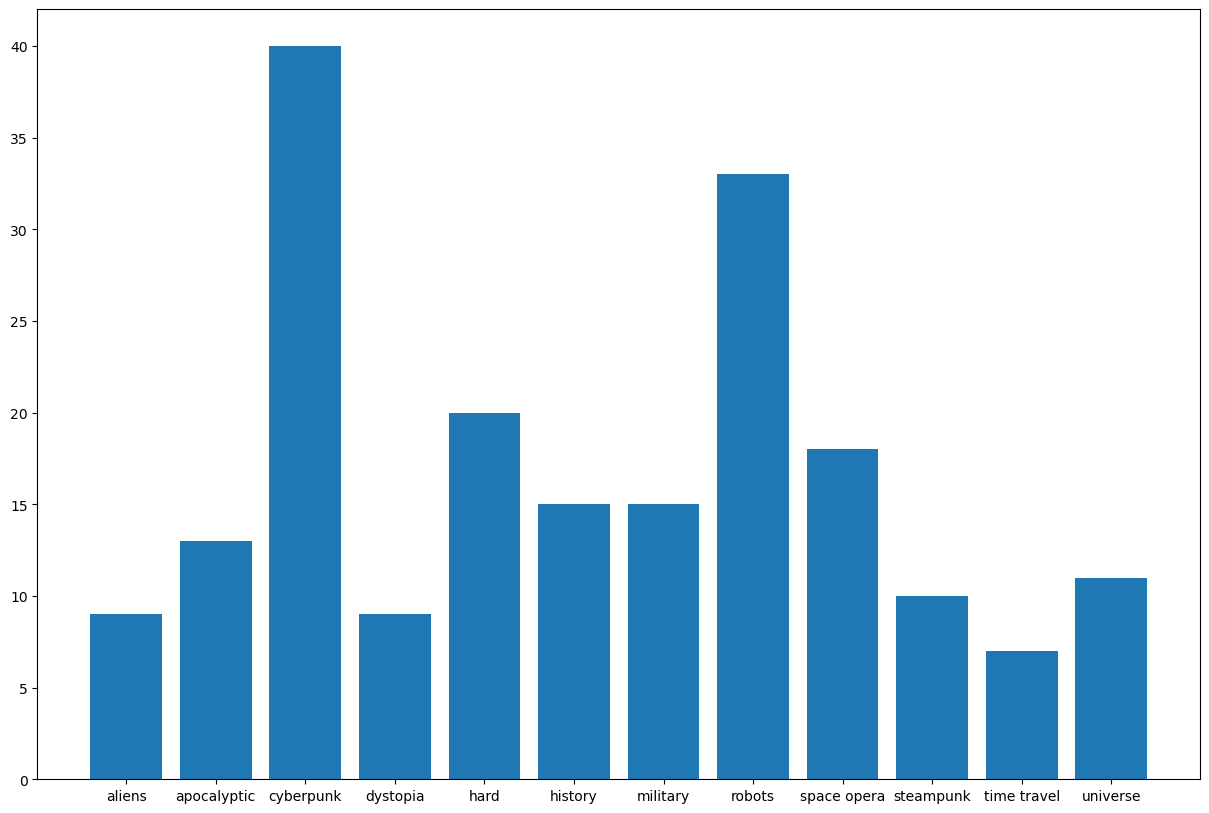

In [262]:
stat = recommend.groupby(['type']).count()
print(stat)

x = stat.index
y = stat.Book_Title

fig = plt.figure()
fig.set_size_inches(15,10)
plt.bar(x,y)

              Book_Title         type  similarity
8981          Prosperity    steampunk    0.976834
1271   Victory of Eagles      history    0.976526
2578   Victory of Eagles     universe    0.976526
10254        The Traitor     dystopia    0.973543
9331             Claimed    steampunk    0.971262
...                  ...          ...         ...
12899        The Expanse     military    0.961545
8128         The Expanse  space opera    0.961545
12476           Resolute     military    0.961492
7802            Resolute  space opera    0.961492
6631      Robots Go Wild       robots    0.961383

[100 rows x 3 columns]
             Book_Title  similarity
type                               
aliens                4           4
apocalyptic           4           4
cyberpunk            16          16
dystopia              6           6
hard                 14          14
history               7           7
military              7           7
robots               13          13
space opera     

<BarContainer object of 12 artists>

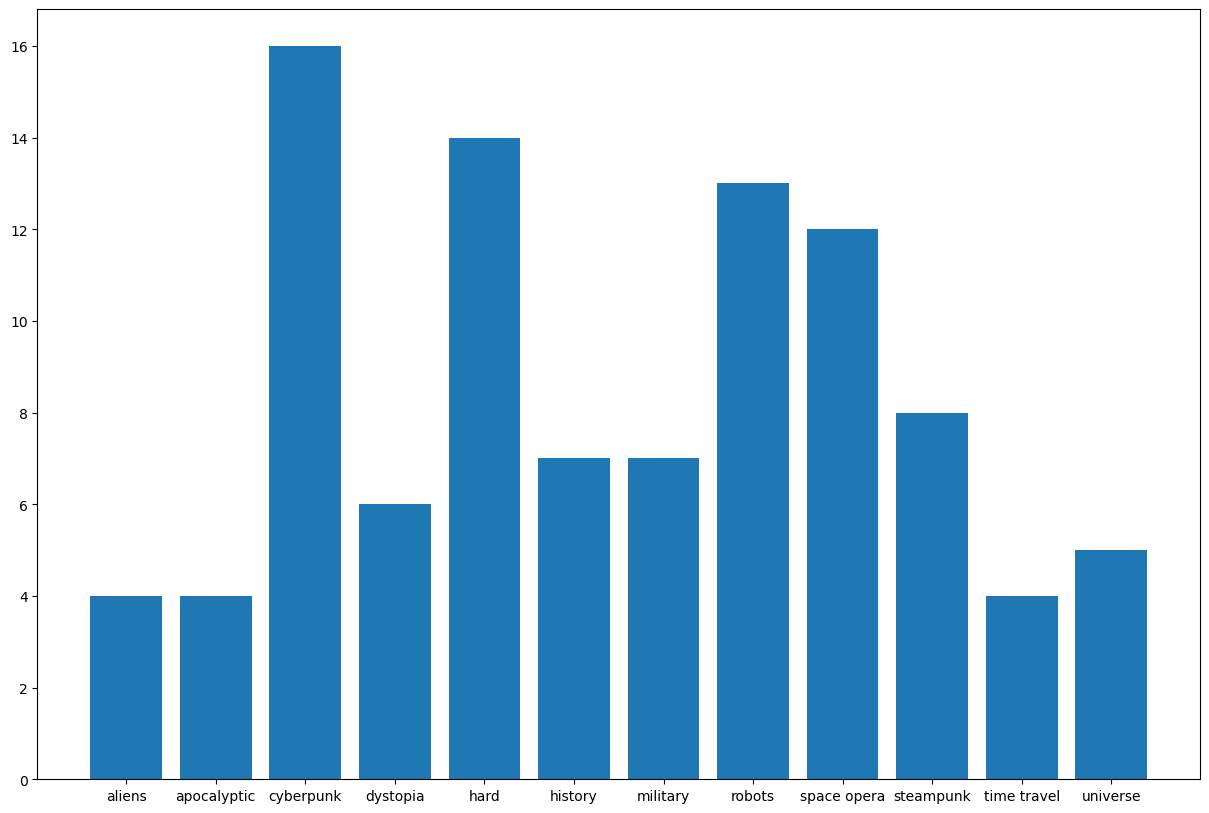

In [263]:
#text = 'Traveling through time in a modified DeLorean car, Marty encounters young versions of his parents (Crispin Glover, Lea Thompson), and must make sure that they fall in love or he\'ll cease to exist. Even more dauntingly, Marty has to return to his own time and save the life of Doc Brown.'
recommend = get_top_k_similarity(k = 100,text = text ,df_topics = df_topics)
print(recommend)

stat = recommend.groupby(['type']).count()
print(stat)

x = stat.index
y = stat.Book_Title

fig = plt.figure()
fig.set_size_inches(15,10)
plt.bar(x,y)